<a href="https://colab.research.google.com/github/jayanth142006/potato-disease-classification-models/blob/main/Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img # Import from tensorflow.keras instead of just keras
import numpy as np
import os
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, ReLU
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os

train_path = '/content/drive/MyDrive/potato_dis_aug'

# Get all class folders
class_names = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]

# Dictionary to store image counts
class_image_counts = {}

# Count images in each class folder
for cls in class_names:
    class_folder = os.path.join(train_path, cls)
    image_files = [f for f in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, f))]
    class_image_counts[cls] = len(image_files)

# Display results
print(f"Total classes: {len(class_names)}\n")
for cls, count in class_image_counts.items():
    print(f"{cls}: {count} images")


Total classes: 7

Pest: 1184 images
Phytopthora: 702 images
Virus: 1050 images
Bacteria: 1106 images
Fungi: 1467 images
Nematode: 659 images
Healthy: 584 images


In [ ]:
import os
import shutil
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Define input and output directories
input_dir = "/content/drive/MyDrive/potato_dis"
output_dir = "/content/drive/MyDrive/potato_dis_aug"
os.makedirs(output_dir, exist_ok=True)

# Augmentation strategy per class
augmentation_map = {
    "Pest": 1,
    "Phytopthora": 1,
    "Virus": 1,
    "Bacteria": 1,
    "Fungi": 1,
    "Nematode": 9,
    "Healthy": 2
}

# ImageDataGenerator settings
aug = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

print("[INFO] Starting augmentation process...")

# Loop through each class
for class_name, aug_count in augmentation_map.items():
    print(f"[INFO] Processing class '{class_name}' with {aug_count} augmentations per image")

    input_class_dir = os.path.join(input_dir, class_name)
    output_class_dir = os.path.join(output_dir, class_name)
    os.makedirs(output_class_dir, exist_ok=True)

    # Filter image files
    image_files = [f for f in os.listdir(input_class_dir) if f.lower().endswith(('jpg', 'jpeg', 'png'))]

    for img_name in image_files:
        img_path = os.path.join(input_class_dir, img_name)

        # Copy original image
        shutil.copy(img_path, os.path.join(output_class_dir, img_name))

        # Prepare for augmentation
        img = load_img(img_path)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        gen = aug.flow(img_array, batch_size=1,
                       save_to_dir=output_class_dir,
                       save_prefix="aug",
                       save_format="jpg")

        # Save augmentations
        total = 0
        for _ in gen:
            total += 1
            if total >= aug_count:
                break

print("[INFO] ✅ All images and augmentations saved successfully.")


[INFO] Starting augmentation process...
[INFO] Processing class 'Pest' with 1 augmentations per image
[INFO] Processing class 'Phytopthora' with 1 augmentations per image
[INFO] Processing class 'Virus' with 1 augmentations per image
[INFO] Processing class 'Bacteria' with 1 augmentations per image
[INFO] Processing class 'Fungi' with 1 augmentations per image
[INFO] Processing class 'Nematode' with 9 augmentations per image
[INFO] Processing class 'Healthy' with 2 augmentations per image
[INFO] ✅ All images and augmentations saved successfully.


In [ ]:
train_path = '/content/drive/MyDrive/potato_dis_aug'
img_size = (299, 299)
batch_size = 32
num_classes = 7 # Adjust based on your dataset

# Data Preprocessing (Augment Train, No Augment Validation)
data_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Splitting 80% train, 20% validation
)

data_gen_valid = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = data_gen_train.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_generator = data_gen_valid.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 5405 images belonging to 7 classes.
Found 1347 images belonging to 7 classes.


In [ ]:
from tensorflow.keras.applications import Xception
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze All Convolutional Layers (Feature Extraction Phase)
for layer in base_model.layers:
    layer.trainable = False

# Build the Classifier on Top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 2349s 14s/step - accuracy: 0.2944 - loss: 1.7607 - val_accuracy: 0.4662 - val_loss: 1.4445
Epoch 2/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.4884 - loss: 1.3432 - val_accuracy: 0.5278 - val_loss: 1.2300
Epoch 3/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.5499 - loss: 1.2041 - val_accuracy: 0.5805 - val_loss: 1.1178
Epoch 4/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.5848 - loss: 1.1220 - val_accuracy: 0.6318 - val_loss: 1.0197
Epoch 5/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.5853 - loss: 1.1115 - val_accuracy: 0.6273 - val_loss: 1.0027
Epoch 6/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.6103 - loss: 1.0578 - val_accuracy: 0.6310 - val_loss: 0.9808
Epoch 7/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.6176 - loss: 1.0551 - val_accuracy: 0.6110 - val_loss: 1.0315
Epoch 8/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.6092 - loss: 1.0313 - val_ac

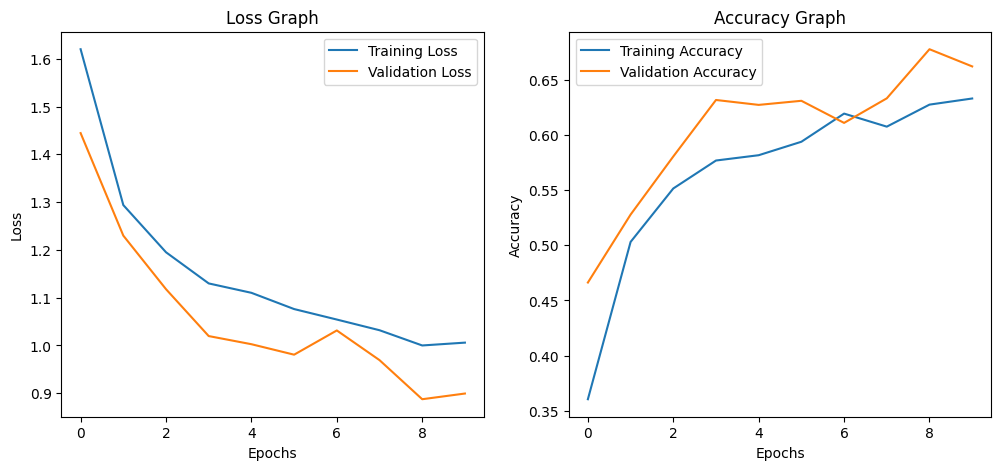

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()

plt.show()


43/43 ━━━━━━━━━━━━━━━━━━━━ 28s 591ms/step
Before Fine-Tuning:
              precision    recall  f1-score   support

    Bacteria       0.93      0.78      0.85       221
       Fungi       0.63      0.65      0.64       293
     Healthy       0.49      0.80      0.61       116
    Nematode       0.87      0.92      0.89       131
        Pest       0.58      0.47      0.52       236
 Phytopthora       0.76      0.67      0.71       140
       Virus       0.62      0.63      0.62       210

    accuracy                           0.68      1347
   macro avg       0.70      0.70      0.69      1347
weighted avg       0.69      0.68      0.68      1347



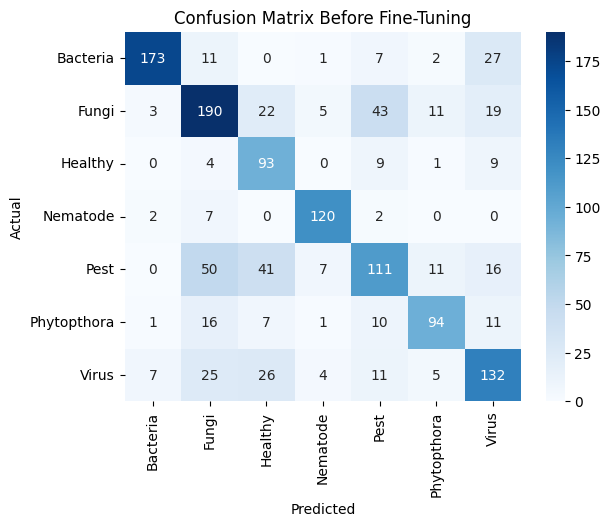

In [ ]:
val_preds = model.predict(valid_generator)
y_true = valid_generator.classes
y_pred = np.argmax(val_preds, axis=1)

# Classification Report
print("Before Fine-Tuning:")
print(classification_report(y_true, y_pred, target_names=valid_generator.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=valid_generator.class_indices.keys(), yticklabels=valid_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Before Fine-Tuning')
plt.show()

In [ ]:
# Fine-Tuning: Unfreeze layers from block10_sepconv1_act onward
for layer in base_model.layers[:86]:
    layer.trainable = False
for layer in base_model.layers[86:]:
    layer.trainable = True

# Compile Model with Lower Learning Rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_finetune = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stopping]
)

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values
train_loss_ft = history_finetune.history['loss']
val_loss_ft = history_finetune.history['val_loss']
train_acc_ft = history_finetune.history['accuracy']
val_acc_ft = history_finetune.history['val_accuracy']

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_ft, label='Training Loss')
plt.plot(val_loss_ft, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Fine-tuning Loss Graph')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_ft, label='Training Accuracy')
plt.plot(val_acc_ft, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Fine-tuning Accuracy Graph')
plt.legend()

plt.show()


In [ ]:
val_preds_ft = model.predict(valid_generator)
y_pred_ft = np.argmax(val_preds_ft, axis=1)

# Classification Report After Fine-Tuning
print("After Fine-Tuning:")
print(classification_report(y_true, y_pred_ft, target_names=valid_generator.class_indices.keys()))

# Confusion Matrix After Fine-Tuning
cm_ft = confusion_matrix(y_true, y_pred_ft)
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Greens', xticklabels=valid_generator.class_indices.keys(), yticklabels=valid_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix After Fine-Tuning')
plt.show()